In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
import numpy as np
from adjustText import adjust_text

In [4]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [5]:
import osmnx
osmnx.config(use_cache=True, log_console=True)

/home/feth/.virtualenvs/jupyter-notebook/lib/python3.11/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [6]:
df = pd.read_json("/home/feth/visu_IPS_jupyter/cached_datasets/fr-en-ips-ecoles-ap2022.json")

In [7]:
gdf = gpd.read_file('/home/feth/visu_IPS_jupyter/cached_datasets/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre.geojson')

In [8]:
def map_ecoles(gdf, title, streets, width, height, school_names=False):
    vmin, vmax = min(gdf.ips), max(gdf.ips)
    emin, emax = min(gdf.effectifs), max(gdf.effectifs)
    cmap = "summer"
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111, title=title)
    ax = streets.plot(ax=ax, linewidth=.25, color='y')
    
    cats = (
        (gdf[gdf['secteur_public_prive_libe'] == 'Public'], 's', 'publiques'),
        (gdf[gdf['secteur_public_prive_libe'] != 'Public'], 'P', 'privées'),
    )
    
    for sub_gdf, marker, label in cats:
        sub_gdf.plot(ax=ax, 
                     column="ips",
                     marker=marker,
                     markersize=sub_gdf.effectifs,
                    edgecolors="black",
                    #legend=True,
                    vmin=vmin,
                    vmax=vmax,
                    cmap=cmap,
                    label='Écoles ' + label,
                 )

    if school_names:
        texts = []
        for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.appellation_officielle):
            texts.append(ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points"))
        adjust_text(texts)
        
    handles, labels = ax.get_legend_handles_labels()
    ax.add_artist(ax.legend(handles, labels))

    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)

    bins = [emin, int((emax - emin)/2) + emin, emax]
    # create second legend
    legend_markers = [Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)] + \
                [
                mlines.Line2D(
                    [],
                    [],
                    color="y",
                    lw=0,
                    marker="o",
                    markeredgecolor="k",
                    markerfacecolor="y",
                    markersize=np.sqrt(b),
                    label=str(int(b)),
                )
                for i, b in enumerate(bins)
            ]
    ax.add_artist(
        ax.legend(
            handles=legend_markers,
            labels=["Effectifs"] + bins,
            loc=4,
        )
    )
    return fig, ax

In [9]:
class Mapper:
    def __init__(self, insee_code, name, place):
        self.insee_code = str(insee_code)
        self.place = place
        self._etab_names = []
        town = df.loc[df['code_insee_de_la_commune'] == insee_code]
        town = town.merge(gdf, left_on='uai', right_on='numero_uai')
        print(town.columns)
        geometry = gpd.points_from_xy(x=town.longitude, y=town.latitude)
        self.geotown = GeoDataFrame(town, crs=gdf.crs, geometry=geometry)
        graph = osmnx.graph_from_place(place)
        nodes, streets  = osmnx.graph_to_gdfs(graph)
        self.streets = streets.to_crs(self.geotown.crs)
        print("Now, make a list of relevant names in the following list and give it to me with obj.set_etab_names(list), then obj.makemap(...)")
        print(self._all_etab_names())
        
    def _all_etab_names(self):
        denom_set = set()
        for item in self.geotown.denomination_principale:
            denom_set.add(item)
        return denom_set
    
    def set_etab_names(self, name_list):
        self._etab_names = name_list
        self.geotown = self.geotown.loc[self.geotown["denomination_principale"].isin(name_list)]
        
    def makemap(self, title, width=10, height=10, school_names=False):
        return map_ecoles(self.geotown, title, self.streets, width, height, school_names=True)

In [10]:
m = Mapper("59512", "Roubaix", "Roubaix, France")

Index(['rentree_scolaire', 'academie', 'code_du_departement', 'departement',
       'uai', 'nom_de_l_etablissment', 'code_insee_de_la_commune',
       'nom_de_la_commune', 'secteur', 'effectifs', 'ips', 'numero_uai',
       'appellation_officielle', 'denomination_principale', 'patronyme_uai',
       'secteur_public_prive_libe', 'adresse_uai', 'lieu_dit_uai',
       'boite_postale_uai', 'code_postal_uai', 'localite_acheminement_uai',
       'libelle_commune', 'coordonnee_x', 'coordonnee_y', 'epsg', 'latitude',
       'longitude', 'appariement', 'localisation', 'nature_uai',
       'nature_uai_libe', 'etat_etablissement', 'etat_etablissement_libe',
       'code_departement', 'code_region', 'code_academie', 'code_commune',
       'libelle_departement', 'libelle_region', 'libelle_academie', 'position',
       'secteur_prive_code_type_contrat', 'secteur_prive_libelle_type_contrat',
       'code_ministere', 'libelle_ministere', 'date_ouverture', 'geometry'],
      dtype='object')
Now, make a

In [11]:
m.set_etab_names(['ECOLE PRIMAIRE PUBLIQUE', 'ECOLE PRIMAIRE', 'ECOLE PRIMAIRE PRIVEE', 'ECOLE ELEMENTAIRE PUBLIQUE'])

<IPython.core.display.Javascript object>


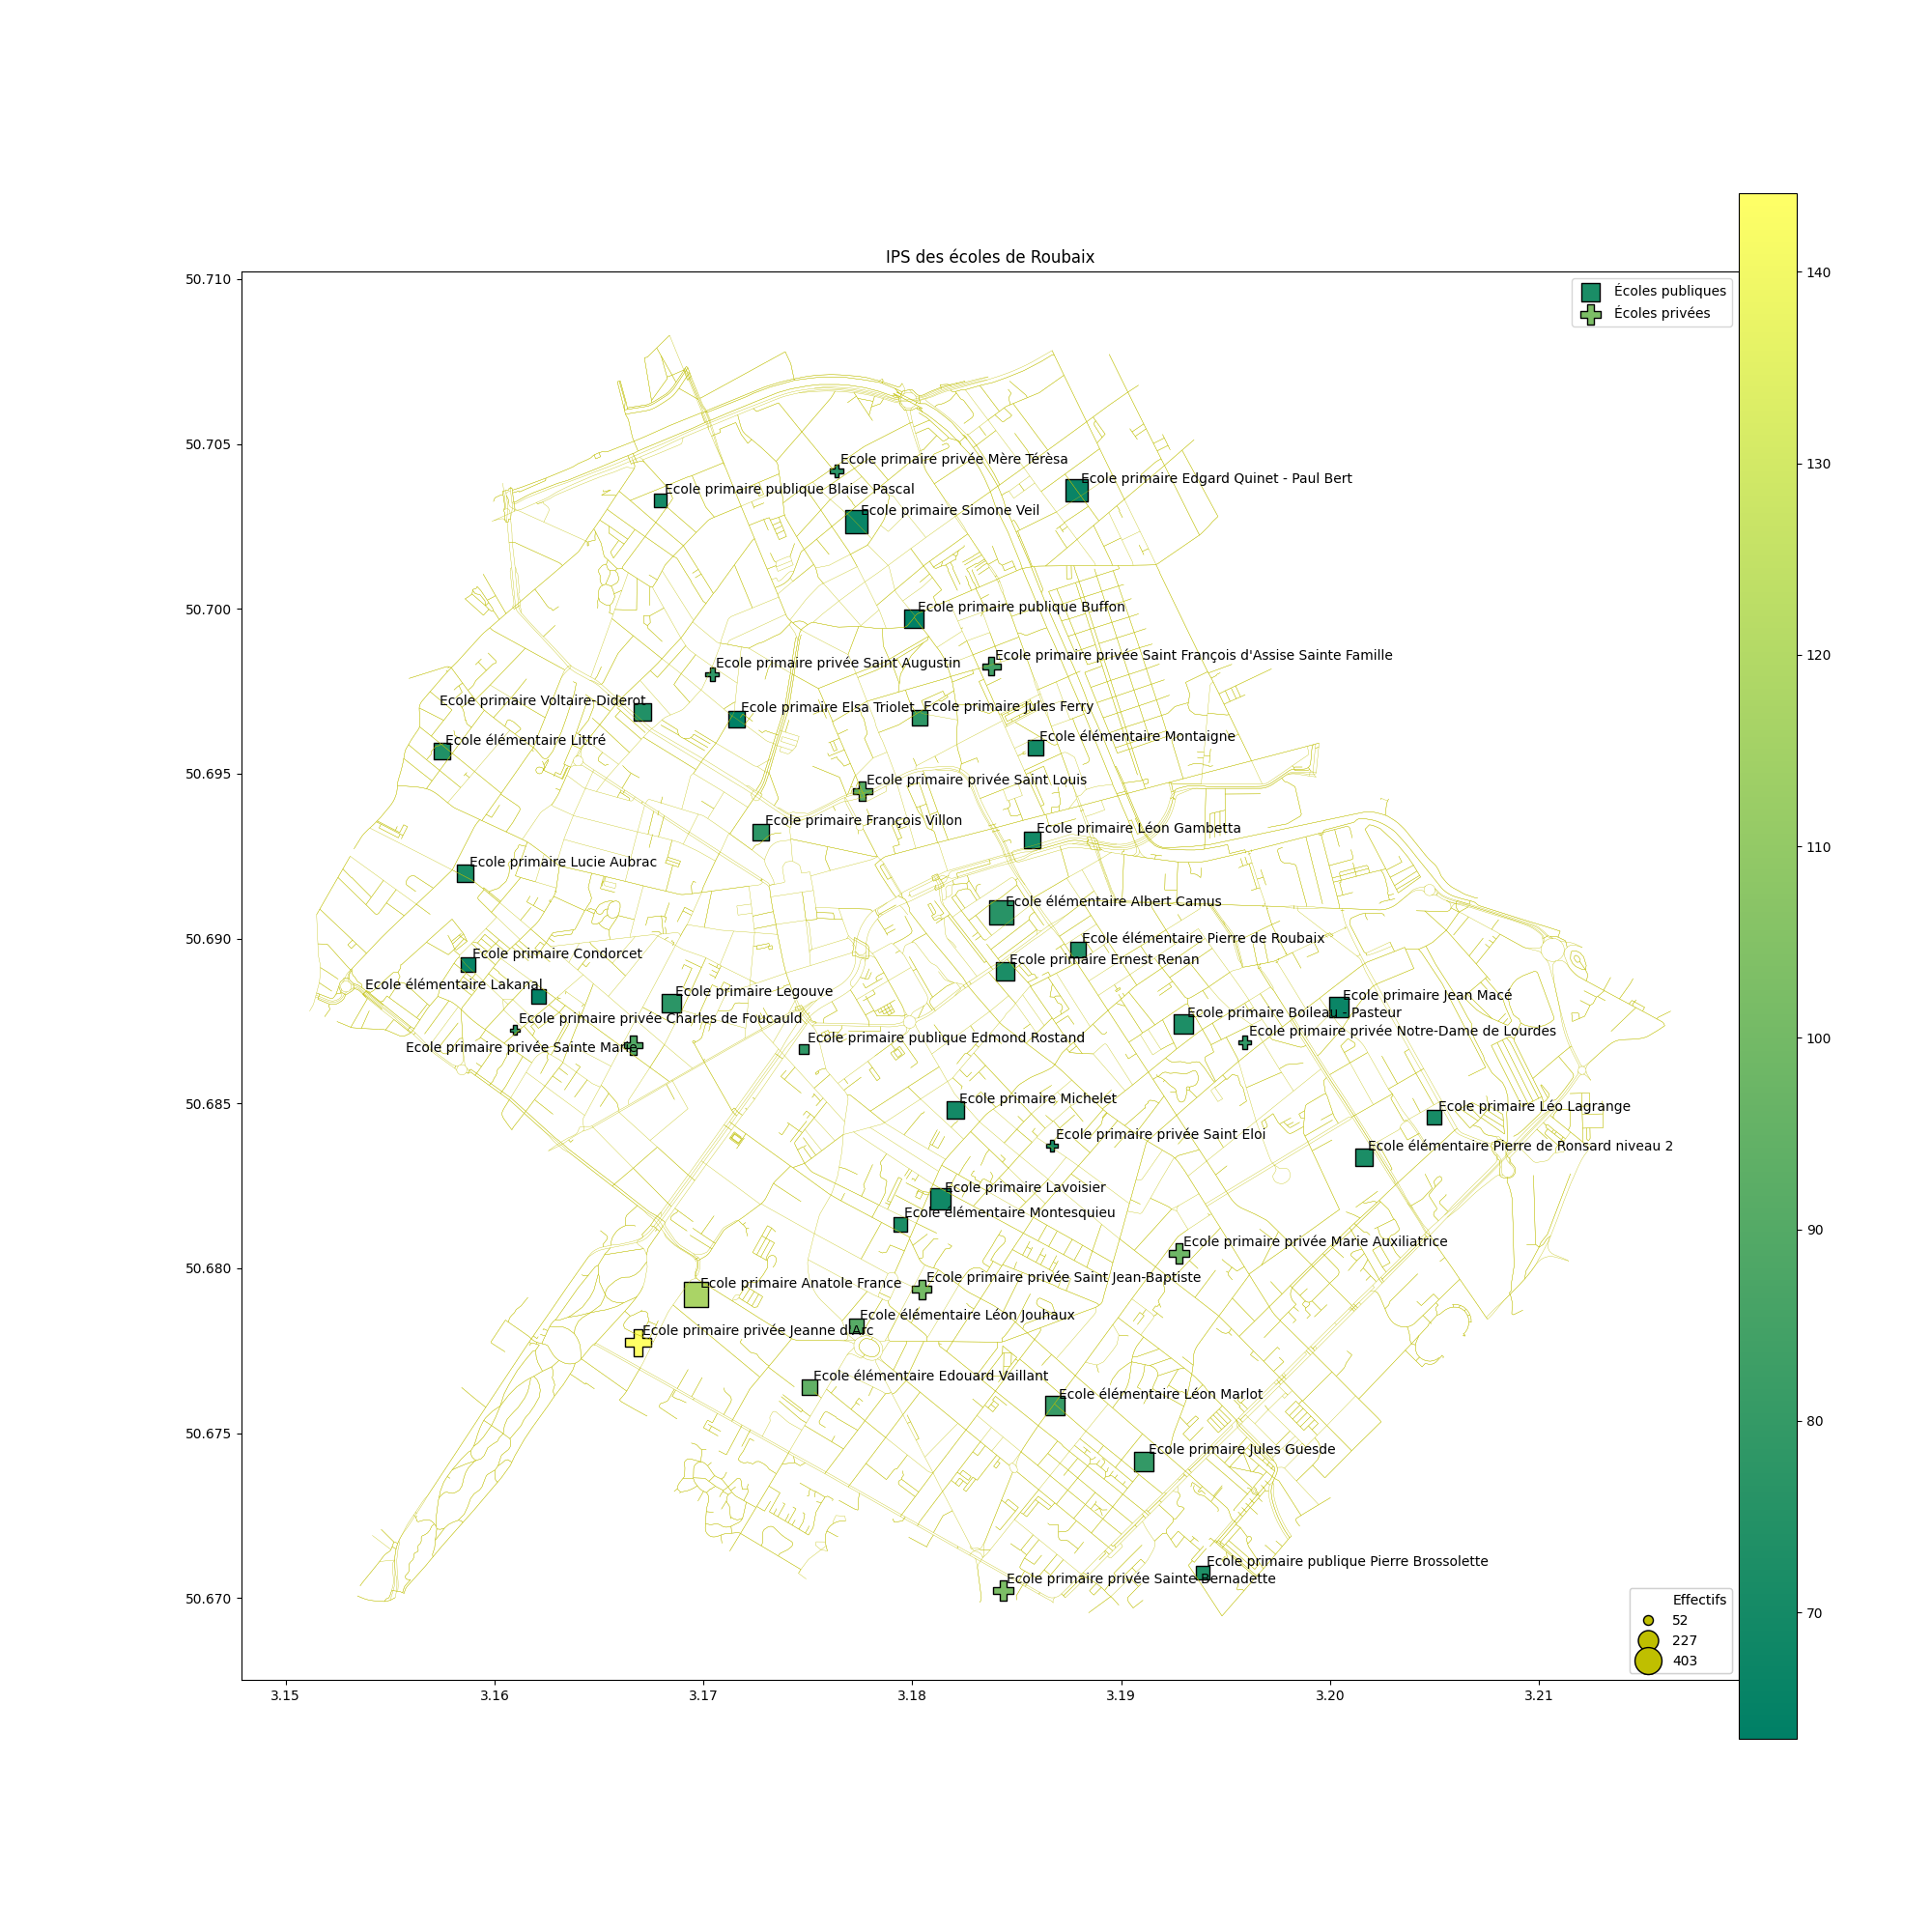

(<Figure size 2000x2000 with 2 Axes>,
 <Axes: title={'center': 'IPS des écoles de Roubaix'}>)

In [12]:
m.makemap("IPS des écoles de Roubaix", width=20, height=20)